# <center><u> GRU - 30 Day Rolling prediction (Univariate)

In [28]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [29]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [30]:
query="""
    select * 
    from agg.tidy_data_30min
    where site = 64
"""

In [31]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_47504/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [32]:
df.set_index('timestamp', inplace=True)
df = df.sort_index()
df

,site,year,month,day,hour,minute,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
timestamp,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,64,2019,4,1,1,0,0,2,14.620,0.0,2.0,97.0,12.0,0.0,0.0,152.86,15.4150,138.56,18.69,0
2019-04-01 00:30:00+00:00,64,2019,4,1,1,30,0,2,16.700,0.0,2.0,97.0,12.0,0.0,0.0,204.52,15.3175,166.11,18.60,0
2019-04-01 01:00:00+00:00,64,2019,4,1,2,0,0,2,20.270,0.0,3.0,99.0,11.0,0.0,0.0,214.66,15.8375,179.70,31.03,0
2019-04-01 01:30:00+00:00,64,2019,4,1,2,30,0,2,15.870,0.0,3.0,99.0,11.0,0.0,0.0,209.72,15.8775,177.33,52.99,0
2019-04-01 02:00:00+00:00,64,2019,4,1,3,0,0,2,15.120,0.0,6.0,100.0,11.0,0.0,0.0,230.59,16.3350,212.62,65.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,64,2020,3,31,21,30,1,2,14.390,NaN,NaN,NaN,NaN,NaN,NaN,282.00,15.4650,264.64,19.82,0
2020-03-31 21:00:00+00:00,64,2020,3,31,22,0,1,2,14.710,NaN,NaN,NaN,NaN,NaN,NaN,321.01,14.5975,220.50,16.55,0
2020-03-31 21:30:00+00:00,64,2020,3,31,22,30,1,2,14.950,NaN,NaN,NaN,NaN,NaN,NaN,353.42,14.7625,206.66,30.23,0


In [33]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))

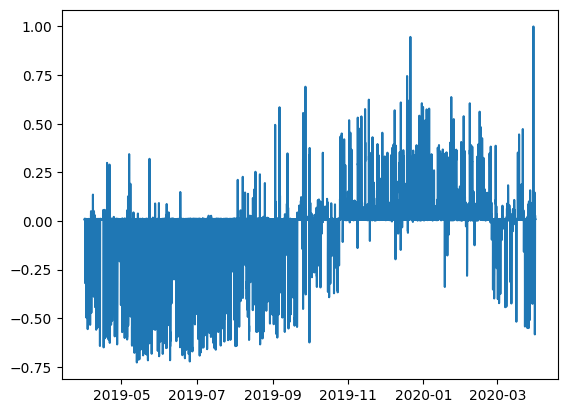

In [34]:
plt.plot(df.index, df.net_load_norm)
plt.show()

## Data Preparation

In [35]:
# Parameters

#n_input = no. of time steps considered before making the prediction
#n_features = no. of variables/features considered
#n_output = no. of time steps to forecast

# Note: 1 time step = 30 mins
# Look at the last two weeks to forecast the next 36 hours

# 1 day = 2 * 24 * 1 = 48
# 6 hours = 2 * 6 = 12 

n_input = 48
n_features = 1
n_output = 12

# Turn net_load_norm into np array
net_load_norm = df['net_load_norm'].to_numpy().reshape(-1, 1)

X, y = [], []
for i in range(len(net_load_norm) - n_input - n_output + 1):
    X.append(net_load_norm[i:(i + n_input), 0])
    y.append(net_load_norm[(i + n_input):(i + n_input + n_output), 0])

X = np.array(X).reshape((len(X), n_input, n_features))
y = np.array(y)

In [36]:
X.shape

(17480, 48, 1)

In [37]:
y.shape

(17480, 12)

In [38]:
print(f'Given the array X: \n {X[0].flatten()}\n')
print(f'Predict this y: \n {y[0]}\n')

Given the array X: 
 [ 0.00781856  0.00893091  0.01084009  0.00848704  0.00808595  0.01163692
  0.01204871  0.00835869  0.0079576   0.00798434  0.00805921  0.00751373
  0.00725169  0.00702173  0.00658855  0.00744956  0.00712334  0.00726238
  0.00750303  0.00727308  0.0073426   0.00754582  0.00788808  0.0072196
  0.0073533  -0.07508918 -0.23238017 -0.25340257 -0.26741929 -0.2747405
 -0.31961431 -0.25242391 -0.10379109  0.00875978  0.00413389  0.00749234
  0.00749234  0.00709125  0.00766347  0.00765277  0.00726773  0.00723564
  0.00812339  0.0079576   0.00774369  0.00798969  0.00802712  0.00760464]

Predict this y: 
 [0.00853517 0.01157275 0.00923039 0.00780786 0.00840682 0.00905391
 0.00823569 0.00859934 0.00782391 0.0080806  0.00852982 0.00703242]



In [39]:
print(f'Given the array X: \n {X[1].flatten()}\n')
print(f'Predict this y: \n {y[1]}\n')

Given the array X: 
 [ 0.00893091  0.01084009  0.00848704  0.00808595  0.01163692  0.01204871
  0.00835869  0.0079576   0.00798434  0.00805921  0.00751373  0.00725169
  0.00702173  0.00658855  0.00744956  0.00712334  0.00726238  0.00750303
  0.00727308  0.0073426   0.00754582  0.00788808  0.0072196   0.0073533
 -0.07508918 -0.23238017 -0.25340257 -0.26741929 -0.2747405  -0.31961431
 -0.25242391 -0.10379109  0.00875978  0.00413389  0.00749234  0.00749234
  0.00709125  0.00766347  0.00765277  0.00726773  0.00723564  0.00812339
  0.0079576   0.00774369  0.00798969  0.00802712  0.00760464  0.00853517]

Predict this y: 
 [0.01157275 0.00923039 0.00780786 0.00840682 0.00905391 0.00823569
 0.00859934 0.00782391 0.0080806  0.00852982 0.00703242 0.00748164]



# Train and Test Set Split

In [40]:
# 1 time step = 30 mins

n_split = 2 * 24 * 300 

X_train = X[:n_split]
y_train = y[:n_split]

X_test = X[n_split:]
y_test = y[n_split:]

In [41]:
X_train.shape

(14400, 48, 1)

In [42]:
y_train.shape

(14400, 12)

In [43]:
X_test.shape

(3080, 48, 1)

In [44]:
y_test.shape

(3080, 12)

## GRU Model

### Model 1:

In [45]:
model1 = Sequential()
model1.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model1.add(GRU(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(y_train.shape[1]))

model1.summary()

/Users/adriachimenos/anaconda3/envs/aml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 48, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,668 (88.55 KB)

 Trainable params: 22,668 (88.55 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError(), MeanAbsoluteError()])

In [47]:
history = model1.fit(X_train, y_train, epochs=10, callbacks=[cp1], batch_size=16, validation_split=0.1)

Epoch 1/10


 86/810 ━━━━━━━━━━━━━━━━━━━━ 30:18 3s/step - loss: 0.0288 - mean_absolute_error: 0.0808 - mean_squared_error: 0.0288

KeyboardInterrupt: 

### Model 2:

### Model 3: